In [ ]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import pickle
import re

import urllib.request
from bs4 import BeautifulSoup

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../results/variables")
figures_path = Path("../figures/tmp")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE

nb_path = Path(
    "/gpfs01/berens/user/rgonzalesmarquez/phd/chatgpt-excess-words/scripts"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("mpl_style.txt")).resolve(strict=True))

# Import

In [ ]:
%%time
%%memit

df_tsne = pd.read_parquet(
    berenslab_data_path / "df_tsne_22_24.parquet.gzip",
    engine="pyarrow",
)

peak memory: 3110.89 MiB, increment: 2799.68 MiB
CPU times: user 5.78 s, sys: 1.72 s, total: 7.5 s
Wall time: 5.2 s


In [ ]:
df_tsne.head()

,PMID,Title,Year,Journal,Labels,Countries,x,y,contains_rare,contains_common,colors_class,colors_country
0,17111134,Fabrication and application of carbohydrate mi...,2023,Applied microbiology and biotechnology,microbiology,China,-41.336465,14.301695,False,False,#B79762,#d21820
1,17245552,Molecular cloning and characterization of a cy...,2023,Molecular biology reports,unlabeled,China,-30.471647,21.530552,False,False,lightgrey,#d21820
2,20960239,Novel Cellulase Screening and Optimal Producti...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.087884,31.224746,False,True,#b65141,#d21820
3,21028883,Pulse Radiolysis Studies of Temperature Depend...,2022,Biochemistry,biochemistry,Denmark,-52.883743,36.074506,True,False,#b65141,#474747
4,21544554,Identification and Characterization of a Tryps...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.388757,32.332601,False,True,#b65141,#d21820


In [ ]:
type(df_tsne.PMID.iloc[0])

str

In [ ]:
pmids_dataset = df_tsne.PMID.astype(str).to_numpy()

In [ ]:
tsne = np.load(variables_path / "tsne_sep.npy")

In [ ]:
tsne_rot = np.vstack((-tsne[:, 0], -tsne[:, 1])).T

In [ ]:
# mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")

In [ ]:
# mask_new_retracted_pmids = np.load(variables_path / "mask_new_retracted_pmids.npy")

In [ ]:
# # Retracted PMIDs scraped from PubMed
# retracted_pmids = np.load("../../results/variables/retracted_pmids.npy")

In [ ]:
# # Retracted PMIDs from Retraction Watch
# unique_retracted_pmids_rw_clean_str = np.load(
#     "../../results/variables/unique_retracted_pmids_rw_clean_str.npy"
# )

In [ ]:
# new_retracted_pmids = np.load(
#     "../../results/variables/new_retracted_pmids.npy"
# )

# Retracted papers

## Scrape PMIDs 

In [ ]:
%%time
retracted_pmids_desc = []

for page in range(1, 36):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?term=%22Retracted%20Publication%22[pt]&filter=years.2022-2025&sort=date&sort_order=desc&size="
        + size
        + "&page="
        + page
        + "&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_desc.append(soup.get_text().split()[7:])

retracted_pmids_desc = np.hstack(retracted_pmids_desc)

CPU times: user 390 ms, sys: 33.6 ms, total: 423 ms
Wall time: 29.8 s


In [ ]:
np.save(variables_path / "retracted_pmids_desc", retracted_pmids_desc)

In [ ]:
%%time
retracted_pmids_asc = []

for page in range(1, 21):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?term=%22Retracted%20Publication%22[pt]&filter=years.2022-2025&sort=date&sort_order=desc&size="
        + size
        + "&page="
        + page
        + "&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_asc.append(soup.get_text().split()[7:])

retracted_pmids_asc = np.hstack(retracted_pmids_asc)

CPU times: user 203 ms, sys: 16.3 ms, total: 219 ms
Wall time: 6.06 s


In [ ]:
np.save(variables_path / "retracted_pmids_asc", retracted_pmids_asc)

In [ ]:
# retracted_pmids_asc = np.load(variables_path / "retracted_pmids_asc.npy")
# retracted_pmids_desc = np.load(variables_path / "retracted_pmids_desc.npy")

In [ ]:
retracted_pmids = np.unique(
    np.hstack((retracted_pmids_desc, retracted_pmids_asc))
)
retracted_pmids.shape

(7000,)

In [ ]:
np.save(variables_path / "retracted_pmids", retracted_pmids)

### Mask

In [ ]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [ ]:
%%time
dict_map = dict()
for elem in retracted_pmids:
    dict_map[elem] = 1

CPU times: user 6.19 ms, sys: 19 μs, total: 6.2 ms
Wall time: 5.57 ms


In [ ]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 200 ms, sys: 1.94 ms, total: 202 ms
Wall time: 199 ms


In [ ]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 180 ms, sys: 4.8 ms, total: 185 ms
Wall time: 183 ms


In [ ]:
mask_retracted_pmids = pre_mask == 1

In [ ]:
np.sum(mask_retracted_pmids)

np.int64(6779)

In [ ]:
np.save(variables_path / "mask_retracted_pmids", mask_retracted_pmids)

## Retraction watch PMIDs

In [ ]:
retraction_watch_data = pd.read_csv(
    "/gpfs01/berens/user/rgonzalesmarquez/phd/pubmed-landscape/data/retractions.csv"
)

In [ ]:
retraction_watch_data.columns

Index(['Record ID', 'Title', 'Subject', 'Institution', 'Journal', 'Publisher',
       'Country', 'Author', 'URLS', 'ArticleType', 'RetractionDate',
       'RetractionDOI', 'RetractionPubMedID', 'OriginalPaperDate',
       'OriginalPaperDOI', 'OriginalPaperPubMedID', 'RetractionNature',
       'Reason', 'Paywalled', 'Notes', 'Approved Status'],
      dtype='object')

In [ ]:
rw_years = retraction_watch_data.OriginalPaperDate.str.extract(
    "([12]\d\d\d)"
).values.astype(int)

In [ ]:
print(
    f"There are {np.sum(retraction_watch_data.OriginalPaperPubMedID != 0)} retracted papers with PMIDs != 0"
)

There are 25382 retracted papers with PMIDs != 0


In [ ]:
retraction_watch_data_22_24 = retraction_watch_data[
    (rw_years >= 2022) & (rw_years <= 2024)
]
retraction_watch_data_22_24.head()

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,...,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes,Approved Status
4,47527,Computer-aided design combined with 3D-printed...,(B/T) Computer Science;(B/T) Technology;(HSC) ...,"Clinical College of Orthopedics, Tianjin Medic...",International Orthopaedics,Springer,China,Jiahui Chen;Jianxiong Ma;Ying Wang;Haohao Bai;...,NaN,Research Article;,...,10.1007/s00264-023-05980-x,37702843.0,4/17/2023 0:00,10.1007/s00264-023-05798-7,37067550.0,Retraction,+Concerns/Issues About Data;+Unreliable Results;,No,NaN,Approved by gms57@pitt.edu on Sep 19 2023 9:21AM
8,47523,Clinical performance of various bonding agents...,(HSC) Medicine - Dentistry;(PHY) Materials Sci...,Department of Conservative Dentistry and Endod...,Journal of Conservative Dentistry (JCD),Wolters Kluwer - Medknow,India,Aashish Handa;Kanwalpreet Kaur Bhullar;Diksha ...,NaN,Research Article;,...,10.4103/5555-1111.382422,37705545.0,5/16/2023 0:00,10.4103/jcd.jcd_265_22,37398852.0,Retraction,+Euphemisms for Plagiarism;+Plagiarism of Arti...,No,NaN,Approved by rheaphine@gmail.com on Sep 20 2023...
11,47520,Data analysis and personalized recommendation ...,(B/T) Computer Science;(B/T) Data Science;(HUM...,"School of Music, Drama and Dance, The Herzen S...",PLoS One,PLoS,Russia,Zongye Yang,NaN,Research Article;,...,10.1371/journal.pone.0291707,37708196.0,1/26/2022 0:00,10.1371/journal.pone.0262697,35081140.0,Retraction,+Concerns/Issues About Data;+Concerns/Issues A...,No,NaN,Approved by gms57@pitt.edu on Sep 19 2023 8:49AM
12,47519,Suboptimal dalbavancin dosages in an adult wit...,(HSC) Medicine - Pharmacology;(HSC) Medicine -...,"UniversitÃ© Paris CitÃ©, Assistance Publique-H...",Journal of Antimicrobial Chemotherapy,Oxford Academic,France,SalomÃ© Abdellaoui;Matthieu Gregoire;Marie Dub...,NaN,Letter;Research Article;,...,10.1093/jac/dkad283,37708251.0,3/2/2023 0:00,10.1093/jac/dkad013,36702764.0,Retraction,+Error in Analyses;+Error in Methods;+Error in...,No,NaN,Approved by gms57@pitt.edu on Sep 19 2023 9:06AM
14,47517,Application of LSTM algorithm combined with Ka...,(B/T) Technology;(PHY) Engineering - Electrical;,"College of Automation Engineering, Nanjing Uni...",PLoS One,PLoS,China;United Kingdom,Bo Zeng;Yuxiang Sun;Shaojun Xie,NaN,Research Article;,...,10.1371/journal.pone.0291708,37708130.0,4/14/2022 0:00,10.1371/journal.pone.0263634,35421121.0,Retraction,+Concerns/Issues About Results;+Concerns/Issue...,No,NaN,Approved by gms57@pitt.edu on Sep 19 2023 8:48AM


In [ ]:
retracted_pmids_rw = retraction_watch_data_22_24["OriginalPaperPubMedID"][
    retraction_watch_data_22_24["OriginalPaperPubMedID"] != 0
]
print(
    f"There are {retracted_pmids_rw.shape[0]} retracted papers from retraction watch in 2022-2024"
)

There are 1398 retracted papers from retraction watch in 2022-2024


### NaNs exploration

In [ ]:
print(f"There are {np.sum(np.isnan(retracted_pmids_rw.to_numpy()))} NaNs")

There are 0 NaNs


In [ ]:
retraction_watch_data.loc[
    retracted_pmids_rw[np.isnan(retracted_pmids_rw.to_numpy())].index
]

,Record ID,Title,Subject,Institution,Journal,Publisher,Country,Author,URLS,ArticleType,...,RetractionDOI,RetractionPubMedID,OriginalPaperDate,OriginalPaperDOI,OriginalPaperPubMedID,RetractionNature,Reason,Paywalled,Notes,Approved Status


In [ ]:
retracted_pmids_rw_clean = retracted_pmids_rw[
    ~np.isnan(retracted_pmids_rw.to_numpy())
]
print(
    f"There are actually {len(retracted_pmids_rw_clean)} retracted papers with PMIDs"
)

There are actually 1398 retracted papers with PMIDs


### Check for duplicates

In [ ]:
retracted_pmids_rw_clean

4        37067550.0
8        37398852.0
11       35081140.0
12       36702764.0
14       35421121.0
            ...    
11857    35016584.0
12053    35223640.0
12358    33035634.0
12386    35070574.0
12410    35026129.0
Name: OriginalPaperPubMedID, Length: 1398, dtype: float64

In [ ]:
unique_retracted_pmids_rw_clean = np.unique(retracted_pmids_rw_clean)
print(
    f"There are {len(unique_retracted_pmids_rw_clean)} unique retracted PMIDs"
)

There are 1387 unique retracted PMIDs


### Transform to string

In [ ]:
unique_retracted_pmids_rw_clean_str = np.array(
    [str(int(elem)) for elem in unique_retracted_pmids_rw_clean.tolist()]
)
print(
    f"There are {len(unique_retracted_pmids_rw_clean_str)} unique retracted PMIDs"
)

There are 1387 unique retracted PMIDs


In [ ]:
np.save(
    variables_path / "unique_retracted_pmids_rw_clean_str",
    unique_retracted_pmids_rw_clean_str,
)

### Mask

In [ ]:
unique_retracted_pmids_rw_clean_str
type(pmids_dataset[0])

str

In [ ]:
%%time
dict_map = dict()
for elem in unique_retracted_pmids_rw_clean_str:
    dict_map[elem] = 1

CPU times: user 0 ns, sys: 1.74 ms, total: 1.74 ms
Wall time: 1.46 ms


In [ ]:
len(dict_map)

1387

In [ ]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 178 ms, sys: 13 ms, total: 191 ms
Wall time: 189 ms


In [ ]:
pre_mask

array([None, None, None, ..., None, None, None], dtype=object)

In [ ]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 172 ms, sys: 17.8 ms, total: 190 ms
Wall time: 187 ms


In [ ]:
np.sum(pre_mask)

1295

In [ ]:
mask_retracted_pmids_rw = pre_mask == 1

In [ ]:
np.sum(mask_retracted_pmids_rw)

np.int64(1295)

In [ ]:
np.save(variables_path / "mask_retracted_pmids_rw", mask_retracted_pmids_rw)

## Difference (only new PMIDs)

### Check how many of them are there in the scraped ids

In [ ]:
retracted_pmids = np.load(variables_path / "retracted_pmids.npy")

In [ ]:
retracted_pmids

array(['34699315', '34704516', '34705582', ..., '39575838', '39624547',
       '39691142'], dtype='<U8')

In [ ]:
print(
    f"The old set has {len(set(retracted_pmids).difference(set(unique_retracted_pmids_rw_clean_str)))} papers that are not in the new set"
)
print(
    f"The new set has {len(set(unique_retracted_pmids_rw_clean_str).difference(set(retracted_pmids)))} papers that are not in the old set"
)

The old set has 5716 papers that are not in the new set
The new set has 103 papers that are not in the old set


In [ ]:
print(
    f"The old set has {len(set(pmids_dataset[mask_retracted_pmids]).difference(set(pmids_dataset[mask_retracted_pmids_rw])))} papers that are not in the new set, contained in our dataset"
)
print(
    f"The new set has {len(set(pmids_dataset[mask_retracted_pmids_rw]).difference(set(pmids_dataset[mask_retracted_pmids])))} papers that are not in the old set, contained in our dataset"
)

The old set has 5538 papers that are not in the new set, contained in our dataset
The new set has 54 papers that are not in the old set, contained in our dataset


### Mask

In [ ]:
new_retracted_pmids = set(unique_retracted_pmids_rw_clean_str).difference(
    set(retracted_pmids)
)

In [ ]:
np.save(
    variables_path / "new_retracted_pmids", np.array(list(new_retracted_pmids))
)

In [ ]:
len(new_retracted_pmids)

103

In [ ]:
%%time
dict_map = dict()
for elem in new_retracted_pmids:
    dict_map[elem] = 1

CPU times: user 148 μs, sys: 20 μs, total: 168 μs
Wall time: 472 μs


In [ ]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 187 ms, sys: 5.66 ms, total: 192 ms
Wall time: 189 ms


In [ ]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 187 ms, sys: 2.76 ms, total: 189 ms
Wall time: 187 ms


In [ ]:
mask_new_retracted_pmids = pre_mask == 1

In [ ]:
np.sum(mask_new_retracted_pmids)

np.int64(54)

In [ ]:
np.save(variables_path / "mask_new_retracted_pmids", mask_new_retracted_pmids)

# Mentions in the abstract
We extract the papers that mention the following words ("retracted", "retraction", "withdrawal") in the abstract to exclude them from the plot. We want to highlight only retracted papers that do not explicitly state in their abstract that they have been retracted.

In [ ]:
mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")
mask_retracted_pmids_rw = np.load(
    variables_path / "mask_retracted_pmids_rw.npy"
)
mask_new_retracted_pmids = np.load(
    variables_path / "mask_new_retracted_pmids.npy"
)

## Scraped

In [ ]:
%%time
%%memit

df = pd.read_parquet(
    berenslab_data_path / "pubmed_baseline_2025.parquet.gzip",
    engine="pyarrow",
)

peak memory: 91655.77 MiB, increment: 88752.58 MiB
CPU times: user 3min 9s, sys: 36.8 s, total: 3min 46s
Wall time: 2min 6s


In [ ]:
abstracts = df.AbstractText[(df.Year >= 2022) & (df.Year <= 2024)][
    mask_retracted_pmids
]

In [ ]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted)[0]),
)

Number of papers with uncapitalized word ' retracted':  66
Number of papers with capitalized word 'Retracted':  14
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  66


In [ ]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction)[0]),
)

Number of papers with uncapitalized word ' retraction':  32
Number of papers with capitalized word 'Retraction':  11
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  33


In [ ]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  27
Number of papers with capitalized word 'Withdrawal':  54
Number of papers with uppercased word 'WITHDRAWAL':  1
Number of total papers with withdrawal:  79


In [ ]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  33
Number of papers with capitalized word 'Withdrawn':  1
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  33


In [ ]:
print(
    f"There are {np.sum((~mask_retraction)& (~mask_retracted)& (~mask_withdrawal)& (~mask_withdrawn))} intact papers"
)

There are 6658 intact papers


## Retraction watch

In [ ]:
abstracts = df.AbstractText[(df.Year >= 2022) & (df.Year <= 2024)][
    mask_retracted_pmids_rw
]

In [ ]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_rw)[0]),
)

Number of papers with uncapitalized word ' retracted':  23
Number of papers with capitalized word 'Retracted':  1
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  23


In [ ]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_rw)[0]),
)

Number of papers with uncapitalized word ' retraction':  8
Number of papers with capitalized word 'Retraction':  1
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  8


In [ ]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  1
Number of papers with capitalized word 'Withdrawal':  30
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  31


In [ ]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_rw = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_rw)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  9
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  9


In [ ]:
print(
    f"There are {np.sum((~mask_retraction_rw)& (~mask_retracted_rw)& (~mask_withdrawal_rw)& (~mask_withdrawn_rw))} intact papers"
)

There are 1258 intact papers


## Difference (only new PMIDs)

In [ ]:
abstracts = df.AbstractText[(df.Year >= 2022) & (df.Year <= 2024)][
    mask_new_retracted_pmids
]

In [ ]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted_new)[0]),
)

Number of papers with uncapitalized word ' retracted':  1
Number of papers with capitalized word 'Retracted':  0
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  1


In [ ]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction_new)[0]),
)

Number of papers with uncapitalized word ' retraction':  0
Number of papers with capitalized word 'Retraction':  0
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  0


In [ ]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal_new)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  0
Number of papers with capitalized word 'Withdrawal':  6
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  6


In [ ]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn_new = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn_new)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  4
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  4


In [ ]:
print(
    f"There are {np.sum((~mask_retraction_new)& (~mask_retracted_new)& (~mask_withdrawal_new)& (~mask_withdrawn_new))} intact papers"
)

There are 48 intact papers


## Intact PMIDs

In [ ]:
intact_retracted_pmids = pmids_dataset[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]
print(intact_retracted_pmids.shape)
np.save(variables_path / "intact_retracted_pmids", intact_retracted_pmids)

(6658,)


In [ ]:
intact_retracted_pmids_rw = pmids_dataset[mask_retracted_pmids_rw][
    (~mask_retraction_rw)
    & (~mask_retracted_rw)
    & (~mask_withdrawal_rw)
    & (~mask_withdrawn_rw)
]
print(intact_retracted_pmids_rw.shape)
np.save(
    variables_path / "intact_retracted_pmids_rw", intact_retracted_pmids_rw
)

(1258,)


In [ ]:
intact_new_retracted_pmids = pmids_dataset[mask_new_retracted_pmids][
    (~mask_retraction_new)
    & (~mask_retracted_new)
    & (~mask_withdrawal_new)
    & (~mask_withdrawn_new)
]
print(intact_new_retracted_pmids.shape)
np.save(
    variables_path / "intact_new_retracted_pmids", intact_new_retracted_pmids
)

(48,)


### Obtain boolean for all intact PMIDs

In [ ]:
%%time
dict_map = dict()
for elem in intact_retracted_pmids:
    dict_map[elem] = 1

for elem in intact_retracted_pmids_rw:
    dict_map[elem] = 1

CPU times: user 3.52 ms, sys: 0 ns, total: 3.52 ms
Wall time: 3.58 ms


In [ ]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 205 ms, sys: 4.89 ms, total: 210 ms
Wall time: 207 ms


In [ ]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 186 ms, sys: 4.82 ms, total: 191 ms
Wall time: 190 ms


In [ ]:
mask_all_intact_retracted_pmids = pre_mask == 1

In [ ]:
np.sum(mask_all_intact_retracted_pmids)

np.int64(6706)

In [ ]:
np.save(
    variables_path / "mask_all_intact_retracted_pmids",
    mask_all_intact_retracted_pmids,
)

### Add it to the dataframe
Column with intact retracted papers

In [ ]:
mask_all_intact_retracted_pmids = np.load(
    variables_path / "mask_all_intact_retracted_pmids.npy",
)

In [ ]:
mask_all_intact_retracted_pmids

array([False, False, False, ..., False, False, False])

In [ ]:
df_tsne.head()

,PMID,Title,Year,Journal,Labels,Countries,x,y,contains_rare,contains_common,colors_class,colors_country
0,17111134,Fabrication and application of carbohydrate mi...,2023,Applied microbiology and biotechnology,microbiology,China,-41.336465,14.301695,False,False,#B79762,#d21820
1,17245552,Molecular cloning and characterization of a cy...,2023,Molecular biology reports,unlabeled,China,-30.471647,21.530552,False,False,lightgrey,#d21820
2,20960239,Novel Cellulase Screening and Optimal Producti...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.087884,31.224746,False,True,#b65141,#d21820
3,21028883,Pulse Radiolysis Studies of Temperature Depend...,2022,Biochemistry,biochemistry,Denmark,-52.883743,36.074506,True,False,#b65141,#474747
4,21544554,Identification and Characterization of a Tryps...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.388757,32.332601,False,True,#b65141,#d21820


In [ ]:
df_tsne["is_retracted"] = mask_all_intact_retracted_pmids

In [ ]:
df_tsne.head()

,PMID,Title,Year,Journal,Labels,Countries,x,y,contains_rare,contains_common,colors_class,colors_country,is_retracted
0,17111134,Fabrication and application of carbohydrate mi...,2023,Applied microbiology and biotechnology,microbiology,China,-41.336465,14.301695,False,False,#B79762,#d21820,False
1,17245552,Molecular cloning and characterization of a cy...,2023,Molecular biology reports,unlabeled,China,-30.471647,21.530552,False,False,lightgrey,#d21820,False
2,20960239,Novel Cellulase Screening and Optimal Producti...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.087884,31.224746,False,True,#b65141,#d21820,False
3,21028883,Pulse Radiolysis Studies of Temperature Depend...,2022,Biochemistry,biochemistry,Denmark,-52.883743,36.074506,True,False,#b65141,#474747,False
4,21544554,Identification and Characterization of a Tryps...,2024,Applied biochemistry and biotechnology,biochemistry,China,-61.388757,32.332601,False,True,#b65141,#d21820,False


In [ ]:
%%time
df_tsne.to_parquet(
    berenslab_data_path / "df_tsne_22_24.parquet.gzip",
    index=False,
    engine="pyarrow",
    compression="gzip",
)

CPU times: user 39.6 s, sys: 587 ms, total: 40.2 s
Wall time: 40.3 s


# Plot

(6706, 2)


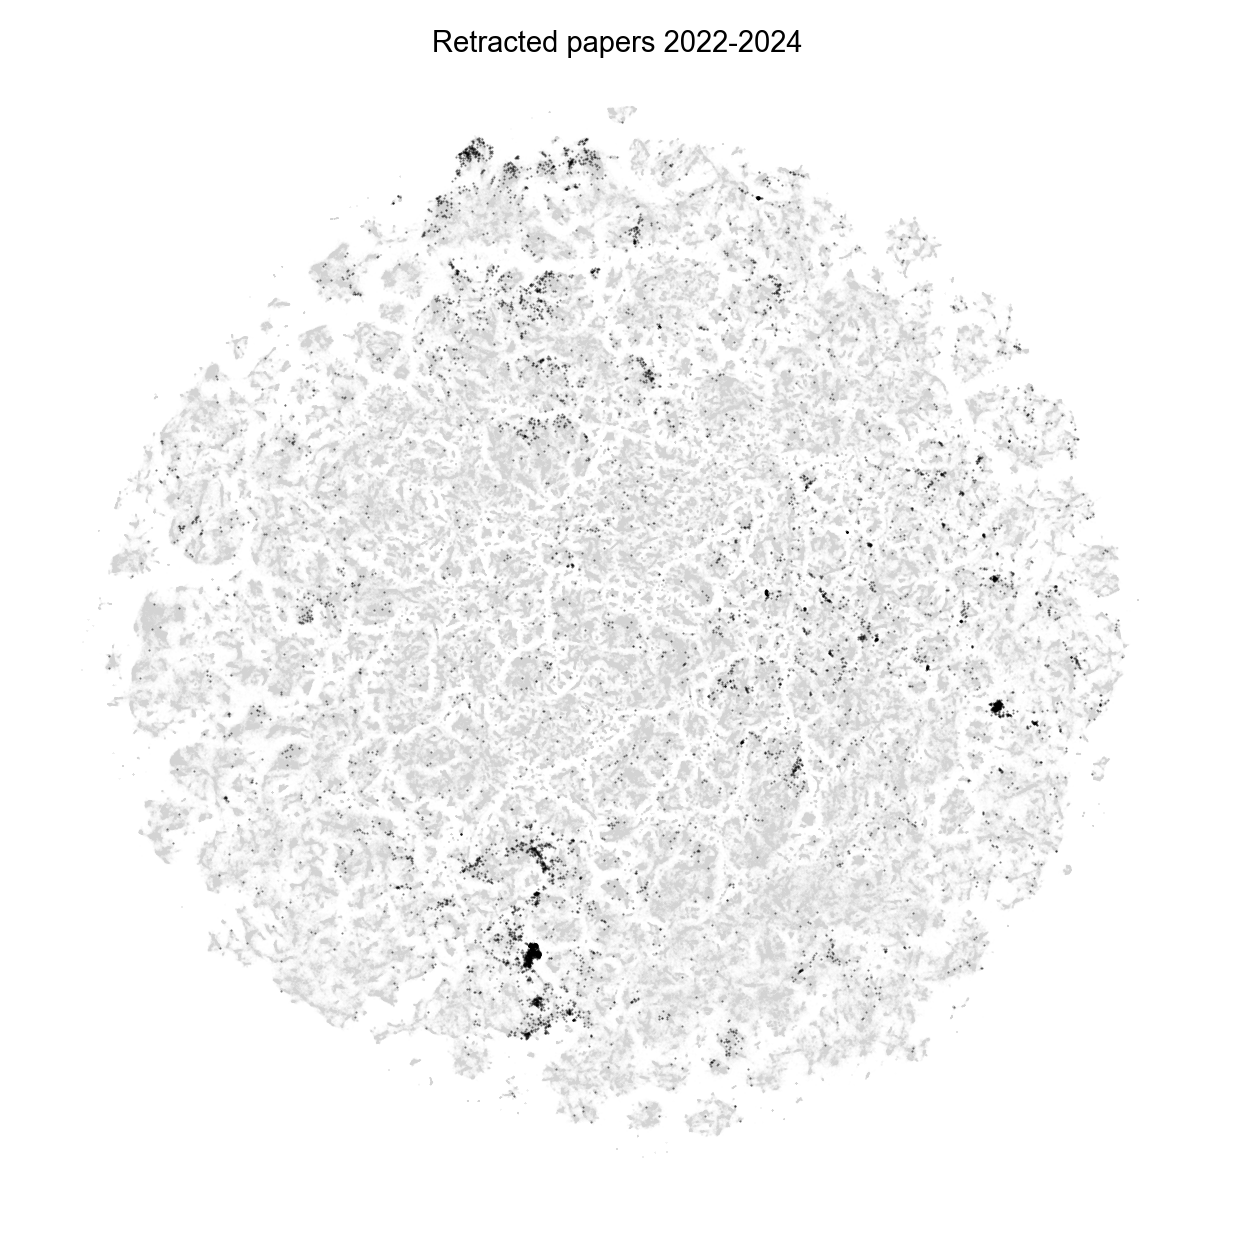

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-120, 120)
y_lim = (-120, 120)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

tsne = tsne_rot

subregion = tsne[mask_all_intact_retracted_pmids]
print(subregion.shape)


ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)


ax.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)


ax.set_title("Retracted papers 2022-2024")
ax.axis("equal")
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.axis("off")

fig.savefig(figures_path / "retracted_papers_plus_rw_v2.png")